In [1]:
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)
# from tensorflow import keras as keras 

1.15.0


Using TensorFlow backend.


2.3.1


In [2]:
# Wczytaj dane treningowe i testowe
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

train_set = pd.read_csv('Dane/adult/adult.data', sep=", ",header = None)
test_set = pd.read_csv('Dane/adult/adult.test', sep=", ",skiprows = 1, header = None) # Make sure to skip a row for the test set

col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
             'wage_class']
train_set.columns = col_labels
test_set.columns = col_labels

train = train_set.replace('?', np.nan).dropna()
test = test_set.replace('?', np.nan).dropna()

train_set.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
dataset = pd.concat([train,test])

dataset['wage_class'] = dataset.wage_class.replace({'<=50K.': 0,'<=50K':0, '>50K.':1, '>50K':1})

dataset.drop(["fnlwgt"],axis=1,inplace=True)

dataset.drop(["education"],axis=1,inplace=True)

x = dataset.groupby('native_country')["wage_class"].mean()

d = dict(pd.cut(x[x.index!=" United-States"],5,labels=range(5)))

dataset['native_country'] = dataset['native_country'].replace(d)

dataset = pd.get_dummies(dataset,drop_first=True)

train = dataset.iloc[:train.shape[0]]
test = dataset.iloc[train.shape[0]:]

X_train = train.drop("wage_class",axis=1)
y_train = train.wage_class

X_test = test.drop("wage_class",axis=1)
y_test = test.wage_class

# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

# print(X_train.shape)
# X_test.shape

In [17]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Activation

from keras.callbacks import History

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate


history_Adam = History()
model = Sequential()
model.add(Dense(100, use_bias=False,input_shape=(X_train.shape[1],)))
model.add(BatchNormalization())
model.add(Activation("sigmoid"))
model.add(Dropout(0.3))
model.add(Dense(50, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("sigmoid"))
model.add(Dropout(0.3))
model.add(Dense(10, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("sigmoid"))
model.add(Dropout(0.3))
model.add(Dense(1,activation="sigmoid"))
model.summary()

Adam = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss="binary_crossentropy",optimizer=Adam, metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)
model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=100, callbacks=[lrate, history_Adam, early_stopping])


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 100)               4100      
_________________________________________________________________
batch_normalization_17 (Batc (None, 100)               400       
_________________________________________________________________
activation_19 (Activation)   (None, 100)               0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 50)                5000      
_________________________________________________________________
batch_normalization_18 (Batc (None, 50)                200       
_________________________________________________________________
activation_20 (Activation)   (None, 50)               

Epoch 42/100
30162/30162 [==============================] - 3s 88us/step - loss: 0.3921 - accuracy: 0.8102 - val_loss: 0.3495 - val_accuracy: 0.8465
Epoch 43/100
30162/30162 [==============================] - 3s 87us/step - loss: 0.3943 - accuracy: 0.8064 - val_loss: 0.3504 - val_accuracy: 0.8462
Epoch 44/100
30162/30162 [==============================] - 3s 87us/step - loss: 0.3926 - accuracy: 0.8074 - val_loss: 0.3498 - val_accuracy: 0.8467
Epoch 45/100
30162/30162 [==============================] - 3s 93us/step - loss: 0.3961 - accuracy: 0.8086 - val_loss: 0.3496 - val_accuracy: 0.8464
Epoch 46/100
30162/30162 [==============================] - 3s 89us/step - loss: 0.3934 - accuracy: 0.8096 - val_loss: 0.3500 - val_accuracy: 0.8454
Epoch 47/100
30162/30162 [==============================] - 3s 87us/step - loss: 0.3903 - accuracy: 0.8090 - val_loss: 0.3496 - val_accuracy: 0.8465
Epoch 48/100
30162/30162 [==============================] - 3s 86us/step - loss: 0.3912 - accuracy: 0.8094

Epoch 00096: early stopping


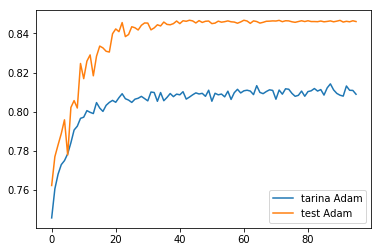

In [18]:
plt.plot(history_Adam.history['accuracy'], label = "tarina Adam")
plt.plot(history_Adam.history['val_accuracy'], label = "test Adam")


plt.legend()
plt.show()

# Zad.
# Zad.
Do do modelu 
 
```python
model.add(Dense( ... , activity_regularizer=l1(0.00001)))
```

w każdej warstwie.

Zwizualizuj wyniki dla obu modeli.

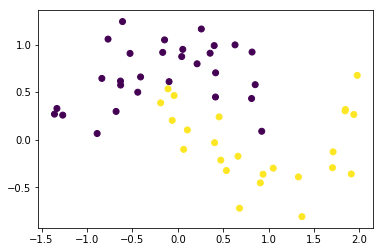

In [19]:
from sklearn.datasets import make_moons
# generate 2d classification dataset
X, y = make_moons(n_samples=100, noise=0.2, random_state=5)
# split into train and test
# n_train = 30
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.70, random_state=2)

n_train=53
X_train, X_test = X[:n_train, :], X[n_train:, :]
y_train, y_test = y[:n_train], y[n_train:]

plt.scatter(X_train[:,0],X_train[:,1], c=y_train)
plt.show()

In [20]:
from keras.callbacks import History


history_Adam = History()
model = Sequential()
model.add(Dense(1000,activation="relu",input_shape=(X_train.shape[1],)))
model.add(Dense(500,activation="sigmoid"))
model.add(Dense(200,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=1000, callbacks=[history_Adam])


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 1000)              3000      
_________________________________________________________________
dense_31 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_32 (Dense)             (None, 200)               100200    
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 201       
Total params: 603,901
Trainable params: 603,901
Non-trainable params: 0
_________________________________________________________________
Train on 53 samples, validate on 47 samples
Epoch 1/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.8130 - accuracy: 0.5472 - val_loss: 0.6743 - val_accuracy: 0.5532
Epoch 2/1000
53/53 [==============================] - 0s 56

53/53 [==============================] - 0s 508us/step - loss: 0.0738 - accuracy: 0.9811 - val_loss: 0.2493 - val_accuracy: 0.8936
Epoch 108/1000
53/53 [==============================] - 0s 470us/step - loss: 0.0711 - accuracy: 0.9811 - val_loss: 0.2427 - val_accuracy: 0.9149
Epoch 109/1000
53/53 [==============================] - 0s 470us/step - loss: 0.0688 - accuracy: 0.9811 - val_loss: 0.2440 - val_accuracy: 0.9149
Epoch 110/1000
53/53 [==============================] - 0s 470us/step - loss: 0.0659 - accuracy: 0.9811 - val_loss: 0.2313 - val_accuracy: 0.9149
Epoch 111/1000
53/53 [==============================] - 0s 452us/step - loss: 0.0658 - accuracy: 0.9811 - val_loss: 0.2102 - val_accuracy: 0.9149
Epoch 112/1000
53/53 [==============================] - 0s 508us/step - loss: 0.0620 - accuracy: 1.0000 - val_loss: 0.2039 - val_accuracy: 0.9149
Epoch 113/1000
53/53 [==============================] - 0s 452us/step - loss: 0.0606 - accuracy: 1.0000 - val_loss: 0.2056 - val_accuracy: 

53/53 [==============================] - 0s 470us/step - loss: 0.0097 - accuracy: 1.0000 - val_loss: 0.1982 - val_accuracy: 0.9149
Epoch 220/1000
53/53 [==============================] - 0s 640us/step - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.2023 - val_accuracy: 0.9149
Epoch 221/1000
53/53 [==============================] - 0s 602us/step - loss: 0.0093 - accuracy: 1.0000 - val_loss: 0.2029 - val_accuracy: 0.9149
Epoch 222/1000
53/53 [==============================] - 0s 489us/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 0.1985 - val_accuracy: 0.9149
Epoch 223/1000
53/53 [==============================] - 0s 489us/step - loss: 0.0089 - accuracy: 1.0000 - val_loss: 0.1959 - val_accuracy: 0.9149
Epoch 224/1000
53/53 [==============================] - 0s 452us/step - loss: 0.0087 - accuracy: 1.0000 - val_loss: 0.1962 - val_accuracy: 0.9149
Epoch 225/1000
53/53 [==============================] - 0s 452us/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.1964 - val_accuracy: 

53/53 [==============================] - 0s 452us/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.2293 - val_accuracy: 0.9149
Epoch 332/1000
53/53 [==============================] - 0s 452us/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.2311 - val_accuracy: 0.9149
Epoch 333/1000
53/53 [==============================] - 0s 452us/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.2305 - val_accuracy: 0.9149
Epoch 334/1000
53/53 [==============================] - 0s 489us/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.2303 - val_accuracy: 0.9149
Epoch 335/1000
53/53 [==============================] - 0s 489us/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.2307 - val_accuracy: 0.9149
Epoch 336/1000
53/53 [==============================] - 0s 470us/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.2313 - val_accuracy: 0.9149
Epoch 337/1000
53/53 [==============================] - 0s 452us/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.2311 - val_accuracy: 

53/53 [==============================] - 0s 470us/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.2680 - val_accuracy: 0.9149
Epoch 444/1000
53/53 [==============================] - 0s 602us/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.2676 - val_accuracy: 0.9149
Epoch 445/1000
53/53 [==============================] - 0s 470us/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.2679 - val_accuracy: 0.9149
Epoch 446/1000
53/53 [==============================] - 0s 508us/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.2690 - val_accuracy: 0.9149
Epoch 447/1000
53/53 [==============================] - 0s 489us/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.2702 - val_accuracy: 0.9149
Epoch 448/1000
53/53 [==============================] - 0s 470us/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.2710 - val_accuracy: 0.9149
Epoch 449/1000
53/53 [==============================] - 0s 452us/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.2708 - val_accuracy: 

Epoch 554/1000
53/53 [==============================] - 0s 489us/step - loss: 7.6675e-04 - accuracy: 1.0000 - val_loss: 0.3174 - val_accuracy: 0.8936
Epoch 555/1000
53/53 [==============================] - 0s 546us/step - loss: 7.4491e-04 - accuracy: 1.0000 - val_loss: 0.3177 - val_accuracy: 0.8936
Epoch 556/1000
53/53 [==============================] - 0s 489us/step - loss: 7.6774e-04 - accuracy: 1.0000 - val_loss: 0.3178 - val_accuracy: 0.8936
Epoch 557/1000
53/53 [==============================] - 0s 452us/step - loss: 7.4129e-04 - accuracy: 1.0000 - val_loss: 0.3184 - val_accuracy: 0.8936
Epoch 558/1000
53/53 [==============================] - 0s 470us/step - loss: 7.6586e-04 - accuracy: 1.0000 - val_loss: 0.3192 - val_accuracy: 0.8936
Epoch 559/1000
53/53 [==============================] - 0s 470us/step - loss: 7.3225e-04 - accuracy: 1.0000 - val_loss: 0.3195 - val_accuracy: 0.8936
Epoch 560/1000
53/53 [==============================] - 0s 546us/step - loss: 7.4227e-04 - accuracy:

Epoch 663/1000
53/53 [==============================] - 0s 452us/step - loss: 4.6877e-04 - accuracy: 1.0000 - val_loss: 0.3583 - val_accuracy: 0.8936
Epoch 664/1000
53/53 [==============================] - 0s 470us/step - loss: 4.6455e-04 - accuracy: 1.0000 - val_loss: 0.3591 - val_accuracy: 0.8936
Epoch 665/1000
53/53 [==============================] - 0s 470us/step - loss: 4.6221e-04 - accuracy: 1.0000 - val_loss: 0.3599 - val_accuracy: 0.8936
Epoch 666/1000
53/53 [==============================] - 0s 527us/step - loss: 4.6695e-04 - accuracy: 1.0000 - val_loss: 0.3602 - val_accuracy: 0.8936
Epoch 667/1000
53/53 [==============================] - 0s 489us/step - loss: 4.6188e-04 - accuracy: 1.0000 - val_loss: 0.3608 - val_accuracy: 0.8936
Epoch 668/1000
53/53 [==============================] - 0s 470us/step - loss: 4.8019e-04 - accuracy: 1.0000 - val_loss: 0.3615 - val_accuracy: 0.8936
Epoch 669/1000
53/53 [==============================] - 0s 508us/step - loss: 4.6378e-04 - accuracy:

Epoch 772/1000
53/53 [==============================] - 0s 470us/step - loss: 3.1502e-04 - accuracy: 1.0000 - val_loss: 0.3933 - val_accuracy: 0.8936
Epoch 773/1000
53/53 [==============================] - 0s 452us/step - loss: 3.0974e-04 - accuracy: 1.0000 - val_loss: 0.3939 - val_accuracy: 0.8936
Epoch 774/1000
53/53 [==============================] - 0s 452us/step - loss: 3.2277e-04 - accuracy: 1.0000 - val_loss: 0.3949 - val_accuracy: 0.8936
Epoch 775/1000
53/53 [==============================] - 0s 470us/step - loss: 3.1159e-04 - accuracy: 1.0000 - val_loss: 0.3953 - val_accuracy: 0.8936
Epoch 776/1000
53/53 [==============================] - 0s 546us/step - loss: 3.1528e-04 - accuracy: 1.0000 - val_loss: 0.3955 - val_accuracy: 0.8936
Epoch 777/1000
53/53 [==============================] - 0s 489us/step - loss: 3.1487e-04 - accuracy: 1.0000 - val_loss: 0.3959 - val_accuracy: 0.8936
Epoch 778/1000
53/53 [==============================] - 0s 470us/step - loss: 3.0641e-04 - accuracy:

Epoch 881/1000
53/53 [==============================] - 0s 527us/step - loss: 2.2898e-04 - accuracy: 1.0000 - val_loss: 0.4229 - val_accuracy: 0.8936
Epoch 882/1000
53/53 [==============================] - 0s 452us/step - loss: 2.2067e-04 - accuracy: 1.0000 - val_loss: 0.4229 - val_accuracy: 0.8936
Epoch 883/1000
53/53 [==============================] - 0s 470us/step - loss: 2.2261e-04 - accuracy: 1.0000 - val_loss: 0.4230 - val_accuracy: 0.8936
Epoch 884/1000
53/53 [==============================] - 0s 489us/step - loss: 2.1965e-04 - accuracy: 1.0000 - val_loss: 0.4229 - val_accuracy: 0.8936
Epoch 885/1000
53/53 [==============================] - 0s 527us/step - loss: 2.1936e-04 - accuracy: 1.0000 - val_loss: 0.4229 - val_accuracy: 0.8936
Epoch 886/1000
53/53 [==============================] - 0s 489us/step - loss: 2.1920e-04 - accuracy: 1.0000 - val_loss: 0.4231 - val_accuracy: 0.8936
Epoch 887/1000
53/53 [==============================] - 0s 452us/step - loss: 2.1860e-04 - accuracy:

Epoch 990/1000
53/53 [==============================] - 0s 470us/step - loss: 1.6733e-04 - accuracy: 1.0000 - val_loss: 0.4473 - val_accuracy: 0.8936
Epoch 991/1000
53/53 [==============================] - 0s 489us/step - loss: 1.6307e-04 - accuracy: 1.0000 - val_loss: 0.4476 - val_accuracy: 0.8936
Epoch 992/1000
53/53 [==============================] - 0s 470us/step - loss: 1.6262e-04 - accuracy: 1.0000 - val_loss: 0.4478 - val_accuracy: 0.8936
Epoch 993/1000
53/53 [==============================] - 0s 470us/step - loss: 1.6444e-04 - accuracy: 1.0000 - val_loss: 0.4481 - val_accuracy: 0.8936
Epoch 994/1000
53/53 [==============================] - 0s 489us/step - loss: 1.6258e-04 - accuracy: 1.0000 - val_loss: 0.4481 - val_accuracy: 0.8936
Epoch 995/1000
53/53 [==============================] - 0s 489us/step - loss: 1.6106e-04 - accuracy: 1.0000 - val_loss: 0.4481 - val_accuracy: 0.8936
Epoch 996/1000
53/53 [==============================] - 0s 470us/step - loss: 1.6131e-04 - accuracy:

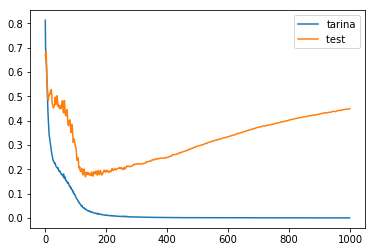

In [21]:
plt.plot(history_Adam.history['loss'], label = "tarina")
plt.plot(history_Adam.history['val_loss'], label = "test ")


plt.legend()
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


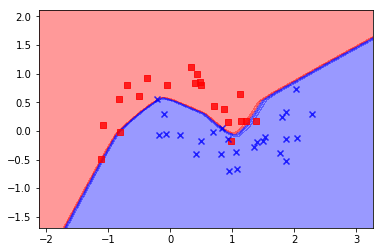

In [22]:
from help_plot import plot_decision_regions
plot_decision_regions(X_test, y_test, model)
plt.show()

In [37]:
from keras.callbacks import History

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate


history_Adam_1 = History()
model = Sequential()
model.add(Dense(1000, use_bias=False,input_shape=(X_train.shape[1],)))
model.add(BatchNormalization())
model.add(Activation("sigmoid"))
model.add(Dropout(0.4))
model.add(Dense(500, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("sigmoid"))
model.add(Dropout(0.4))
model.add(Dense(200, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("sigmoid"))
model.add(Dropout(0.4))
model.add(Dense(1,activation="sigmoid"))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=1000, callbacks=[history_Adam_1])


Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 1000)              2000      
_________________________________________________________________
batch_normalization_32 (Batc (None, 1000)              4000      
_________________________________________________________________
activation_31 (Activation)   (None, 1000)              0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_55 (Dense)             (None, 500)               500000    
_________________________________________________________________
batch_normalization_33 (Batc (None, 500)               2000      
_________________________________________________________________
activation_32 (Activation)   (None, 500)             

Epoch 43/1000
53/53 [==============================] - 0s 640us/step - loss: 0.2537 - accuracy: 0.9057 - val_loss: 0.6612 - val_accuracy: 0.4681
Epoch 44/1000
53/53 [==============================] - 0s 715us/step - loss: 0.3370 - accuracy: 0.9057 - val_loss: 0.6640 - val_accuracy: 0.4681
Epoch 45/1000
53/53 [==============================] - 0s 640us/step - loss: 0.2454 - accuracy: 0.9057 - val_loss: 0.6646 - val_accuracy: 0.4681
Epoch 46/1000
53/53 [==============================] - 0s 640us/step - loss: 0.3327 - accuracy: 0.8491 - val_loss: 0.6606 - val_accuracy: 0.5106
Epoch 47/1000
53/53 [==============================] - 0s 696us/step - loss: 0.2399 - accuracy: 0.8868 - val_loss: 0.6530 - val_accuracy: 0.5106
Epoch 48/1000
53/53 [==============================] - 0s 640us/step - loss: 0.2456 - accuracy: 0.8868 - val_loss: 0.6441 - val_accuracy: 0.5319
Epoch 49/1000
53/53 [==============================] - 0s 696us/step - loss: 0.2851 - accuracy: 0.8679 - val_loss: 0.6362 - val_ac

53/53 [==============================] - 0s 659us/step - loss: 0.2484 - accuracy: 0.9057 - val_loss: 0.4578 - val_accuracy: 0.7660
Epoch 156/1000
53/53 [==============================] - 0s 696us/step - loss: 0.2483 - accuracy: 0.9057 - val_loss: 0.4579 - val_accuracy: 0.7660
Epoch 157/1000
53/53 [==============================] - 0s 659us/step - loss: 0.2378 - accuracy: 0.8868 - val_loss: 0.4580 - val_accuracy: 0.7660
Epoch 158/1000
53/53 [==============================] - 0s 659us/step - loss: 0.3196 - accuracy: 0.8679 - val_loss: 0.4583 - val_accuracy: 0.7660
Epoch 159/1000
53/53 [==============================] - 0s 640us/step - loss: 0.3195 - accuracy: 0.8679 - val_loss: 0.4586 - val_accuracy: 0.7660
Epoch 160/1000
53/53 [==============================] - 0s 640us/step - loss: 0.3261 - accuracy: 0.8491 - val_loss: 0.4605 - val_accuracy: 0.7660
Epoch 161/1000
53/53 [==============================] - 0s 659us/step - loss: 0.2294 - accuracy: 0.9245 - val_loss: 0.4617 - val_accuracy: 

53/53 [==============================] - 0s 621us/step - loss: 0.2431 - accuracy: 0.8679 - val_loss: 0.4185 - val_accuracy: 0.7872
Epoch 268/1000
53/53 [==============================] - 0s 696us/step - loss: 0.3123 - accuracy: 0.8868 - val_loss: 0.4208 - val_accuracy: 0.7872
Epoch 269/1000
53/53 [==============================] - 0s 659us/step - loss: 0.2553 - accuracy: 0.8679 - val_loss: 0.4225 - val_accuracy: 0.7872
Epoch 270/1000
53/53 [==============================] - 0s 715us/step - loss: 0.3308 - accuracy: 0.8679 - val_loss: 0.4242 - val_accuracy: 0.8085
Epoch 271/1000
53/53 [==============================] - 0s 659us/step - loss: 0.3032 - accuracy: 0.8679 - val_loss: 0.4239 - val_accuracy: 0.8085
Epoch 272/1000
53/53 [==============================] - 0s 659us/step - loss: 0.2604 - accuracy: 0.8679 - val_loss: 0.4221 - val_accuracy: 0.8085
Epoch 273/1000
53/53 [==============================] - 0s 696us/step - loss: 0.2152 - accuracy: 0.9057 - val_loss: 0.4208 - val_accuracy: 

53/53 [==============================] - 0s 677us/step - loss: 0.2830 - accuracy: 0.8679 - val_loss: 0.4342 - val_accuracy: 0.8085
Epoch 380/1000
53/53 [==============================] - 0s 621us/step - loss: 0.2329 - accuracy: 0.8868 - val_loss: 0.4318 - val_accuracy: 0.8085
Epoch 381/1000
53/53 [==============================] - 0s 659us/step - loss: 0.3179 - accuracy: 0.9057 - val_loss: 0.4326 - val_accuracy: 0.8298
Epoch 382/1000
53/53 [==============================] - 0s 753us/step - loss: 0.2524 - accuracy: 0.8868 - val_loss: 0.4386 - val_accuracy: 0.8085
Epoch 383/1000
53/53 [==============================] - 0s 1ms/step - loss: 0.3181 - accuracy: 0.8491 - val_loss: 0.4462 - val_accuracy: 0.8085
Epoch 384/1000
53/53 [==============================] - 0s 677us/step - loss: 0.2130 - accuracy: 0.9057 - val_loss: 0.4568 - val_accuracy: 0.8085
Epoch 385/1000
53/53 [==============================] - 0s 677us/step - loss: 0.3106 - accuracy: 0.8679 - val_loss: 0.4652 - val_accuracy: 0.

53/53 [==============================] - 0s 677us/step - loss: 0.2462 - accuracy: 0.8868 - val_loss: 0.4131 - val_accuracy: 0.8298
Epoch 492/1000
53/53 [==============================] - 0s 696us/step - loss: 0.2517 - accuracy: 0.9057 - val_loss: 0.4141 - val_accuracy: 0.8298
Epoch 493/1000
53/53 [==============================] - 0s 677us/step - loss: 0.2207 - accuracy: 0.9245 - val_loss: 0.4098 - val_accuracy: 0.8298
Epoch 494/1000
53/53 [==============================] - 0s 677us/step - loss: 0.2754 - accuracy: 0.9434 - val_loss: 0.4066 - val_accuracy: 0.8298
Epoch 495/1000
53/53 [==============================] - 0s 696us/step - loss: 0.2542 - accuracy: 0.8679 - val_loss: 0.4027 - val_accuracy: 0.8298
Epoch 496/1000
53/53 [==============================] - 0s 677us/step - loss: 0.2899 - accuracy: 0.8868 - val_loss: 0.4018 - val_accuracy: 0.8298
Epoch 497/1000
53/53 [==============================] - 0s 734us/step - loss: 0.2718 - accuracy: 0.8868 - val_loss: 0.4007 - val_accuracy: 

53/53 [==============================] - 0s 696us/step - loss: 0.2543 - accuracy: 0.8868 - val_loss: 0.3256 - val_accuracy: 0.8723
Epoch 604/1000
53/53 [==============================] - 0s 696us/step - loss: 0.3450 - accuracy: 0.8679 - val_loss: 0.3237 - val_accuracy: 0.8723
Epoch 605/1000
53/53 [==============================] - 0s 659us/step - loss: 0.2052 - accuracy: 0.9245 - val_loss: 0.3222 - val_accuracy: 0.8723
Epoch 606/1000
53/53 [==============================] - 0s 715us/step - loss: 0.2503 - accuracy: 0.8868 - val_loss: 0.3226 - val_accuracy: 0.8723
Epoch 607/1000
53/53 [==============================] - 0s 677us/step - loss: 0.3610 - accuracy: 0.8868 - val_loss: 0.3169 - val_accuracy: 0.8723
Epoch 608/1000
53/53 [==============================] - 0s 696us/step - loss: 0.1990 - accuracy: 0.9245 - val_loss: 0.3122 - val_accuracy: 0.8723
Epoch 609/1000
53/53 [==============================] - 0s 715us/step - loss: 0.2017 - accuracy: 0.9057 - val_loss: 0.3050 - val_accuracy: 

53/53 [==============================] - 0s 659us/step - loss: 0.1771 - accuracy: 0.9245 - val_loss: 0.3683 - val_accuracy: 0.8723
Epoch 716/1000
53/53 [==============================] - 0s 734us/step - loss: 0.1786 - accuracy: 0.9057 - val_loss: 0.3739 - val_accuracy: 0.8511
Epoch 717/1000
53/53 [==============================] - 0s 677us/step - loss: 0.2591 - accuracy: 0.8868 - val_loss: 0.3798 - val_accuracy: 0.8511
Epoch 718/1000
53/53 [==============================] - 0s 734us/step - loss: 0.2245 - accuracy: 0.8868 - val_loss: 0.3807 - val_accuracy: 0.8511
Epoch 719/1000
53/53 [==============================] - 0s 696us/step - loss: 0.2461 - accuracy: 0.9245 - val_loss: 0.3720 - val_accuracy: 0.8511
Epoch 720/1000
53/53 [==============================] - 0s 715us/step - loss: 0.1853 - accuracy: 0.9245 - val_loss: 0.3552 - val_accuracy: 0.8723
Epoch 721/1000
53/53 [==============================] - 0s 677us/step - loss: 0.2177 - accuracy: 0.9245 - val_loss: 0.3371 - val_accuracy: 

53/53 [==============================] - 0s 677us/step - loss: 0.2261 - accuracy: 0.9057 - val_loss: 0.2660 - val_accuracy: 0.8723
Epoch 828/1000
53/53 [==============================] - 0s 715us/step - loss: 0.1571 - accuracy: 0.9245 - val_loss: 0.2755 - val_accuracy: 0.8723
Epoch 829/1000
53/53 [==============================] - 0s 659us/step - loss: 0.2006 - accuracy: 0.9245 - val_loss: 0.2882 - val_accuracy: 0.8723
Epoch 830/1000
53/53 [==============================] - 0s 753us/step - loss: 0.2174 - accuracy: 0.8868 - val_loss: 0.3091 - val_accuracy: 0.8723
Epoch 831/1000
53/53 [==============================] - 0s 715us/step - loss: 0.1790 - accuracy: 0.9245 - val_loss: 0.3261 - val_accuracy: 0.8723
Epoch 832/1000
53/53 [==============================] - 0s 715us/step - loss: 0.2406 - accuracy: 0.9245 - val_loss: 0.3391 - val_accuracy: 0.8723
Epoch 833/1000
53/53 [==============================] - 0s 696us/step - loss: 0.1231 - accuracy: 0.9623 - val_loss: 0.3479 - val_accuracy: 

53/53 [==============================] - 0s 715us/step - loss: 0.2523 - accuracy: 0.8868 - val_loss: 0.2866 - val_accuracy: 0.8723
Epoch 940/1000
53/53 [==============================] - 0s 696us/step - loss: 0.1956 - accuracy: 0.9057 - val_loss: 0.2842 - val_accuracy: 0.8723
Epoch 941/1000
53/53 [==============================] - 0s 734us/step - loss: 0.1809 - accuracy: 0.9434 - val_loss: 0.2791 - val_accuracy: 0.8723
Epoch 942/1000
53/53 [==============================] - 0s 696us/step - loss: 0.2642 - accuracy: 0.8679 - val_loss: 0.2717 - val_accuracy: 0.8723
Epoch 943/1000
53/53 [==============================] - 0s 715us/step - loss: 0.1907 - accuracy: 0.9057 - val_loss: 0.2723 - val_accuracy: 0.8723
Epoch 944/1000
53/53 [==============================] - 0s 696us/step - loss: 0.2966 - accuracy: 0.8491 - val_loss: 0.2824 - val_accuracy: 0.8723
Epoch 945/1000
53/53 [==============================] - 0s 659us/step - loss: 0.2136 - accuracy: 0.9245 - val_loss: 0.2910 - val_accuracy: 

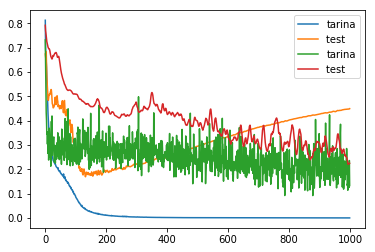

In [38]:
plt.plot(history_Adam.history['loss'], label = "tarina")
plt.plot(history_Adam.history['val_loss'], label = "test ")

plt.plot(history_Adam_1.history['loss'], label = "tarina")
plt.plot(history_Adam_1.history['val_loss'], label = "test ")

plt.legend()
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


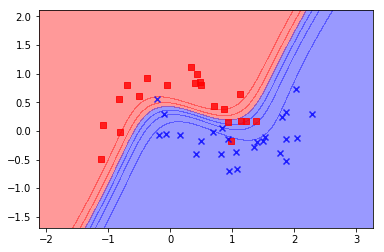

In [39]:
from help_plot import plot_decision_regions
plot_decision_regions(X_test, y_test, model)
plt.show()